# Assignment

## Importing Libraries

In [474]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Datasets

In [475]:
cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())

cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Creating the training dataset

In [476]:
from torch.utils.data import DataLoader
batch_size = 50

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True)

In [477]:
X,y = next(iter(train_iter))

## Creating the test dataset

In [478]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=True)

In [479]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data

In [480]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')
print(f'The output labels are as follows {y}')

The dimensions of each input image is torch.Size([50, 3, 32, 32]) The number of input channels is 3
The output labels are as follows tensor([8, 8, 7, 6, 0, 6, 7, 2, 9, 7, 8, 6, 9, 2, 5, 0, 2, 7, 3, 5, 8, 6, 0, 1,
        2, 9, 0, 0, 2, 4, 3, 0, 4, 7, 7, 6, 7, 1, 2, 3, 3, 1, 2, 5, 5, 3, 9, 0,
        0, 6])


## Example image

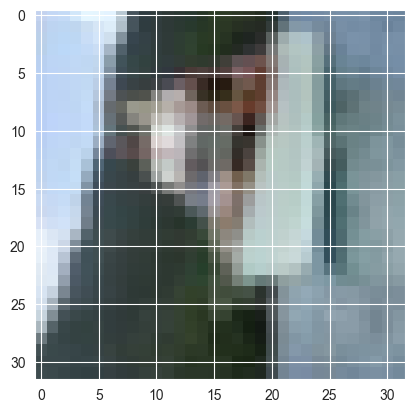

In [481]:
plt.imshow(X[1].T)

## CNN Architecture

In [496]:
class CNN(torch.nn.Module):
    def __init__(self,num_channels,num_outputs):
        super(CNN,self).__init__()
        self.num_channels = num_channels
        self.num_outputs = num_outputs

        #Spatial/Global Pooling for input-------------------------------------------------------
        self.spatial_avg_pool1 = torch.nn.AdaptiveAvgPool2d((24,24))

        # Design the base block Element---------------------------------------------------------
        #Create an input linear layer for future combination

        self.linear1 = torch.nn.Linear(in_features=1728,out_features=2)
        self.relu1 = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(num_channels,out_channels=6,kernel_size=3,stride=2,padding=1)
        self.relu2 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(num_channels,out_channels=8,kernel_size=3,stride=2,padding=1)
        self.relu3 = torch.nn.ReLU()

        # Create Block 2 in the backbone-------------------------------------------------------
        self.linear12 = torch.nn.Linear(in_features=3584,out_features=2)
        self.relu12 = torch.nn.ReLU()

        self.conv12 = torch.nn.Conv2d(in_channels=350,out_channels=6,kernel_size=3,stride=2,padding=1)
        self.relu22 = torch.nn.ReLU()

        self.conv22 = torch.nn.Conv2d(in_channels=350,out_channels=8,kernel_size=3,stride=2,padding=1)
        self.relu32 = torch.nn.ReLU()

        # Create Block 2 in the backbone-------------------------------------------------------
        self.linear13 = torch.nn.Linear(in_features=896,out_features=2)
        self.relu13 = torch.nn.ReLU()

        self.conv13 = torch.nn.Conv2d(in_channels=350,out_channels=6,kernel_size=3,stride=2,padding=1)
        self.relu23 = torch.nn.ReLU()

        self.conv23 = torch.nn.Conv2d(in_channels=350,out_channels=8,kernel_size=3,stride=2,padding=1)
        self.relu33 = torch.nn.ReLU()

        # Create the spatial average pooling layer for the inputs to the dense---------------------
        self.spatial_avg_pool2 = torch.nn.AdaptiveAvgPool1d(20)

        # Create the dense,classification block----------------------------------------------------
        # First FC linear layer
        self.linear2 = torch.nn.Linear(in_features=20,out_features=num_outputs)
        self.relu4 = torch.nn.ReLU()

        # Softmax application to get probabilities of classes
        self.softmax = torch.nn.Softmax(dim=1)

        #Initialize the weights and the bias for the linear layer
        # First blocks linear layer
        torch.nn.init.kaiming_normal_(self.linear1.weight,nonlinearity='relu')
        torch.nn.init.zeros_(self.linear1.bias)

        #Second blocks linear layer
        torch.nn.init.kaiming_normal_(self.linear12.weight,nonlinearity='relu')
        torch.nn.init.zeros_(self.linear12.bias)

        #Third blocks linear layer
        torch.nn.init.kaiming_normal_(self.linear13.weight,nonlinearity='relu')
        torch.nn.init.zeros_(self.linear13.bias)

        #Final linear layer
        torch.nn.init.kaiming_normal_(self.linear2.weight,nonlinearity='relu')
        torch.nn.init.zeros_(self.linear2.bias)

        #Define the proportion of neurons to dropout
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self,x):
        # Applying average pooling to downsample the image from 32 -> 24
        a = self.spatial_avg_pool1(x)

        # First Block------------------------------------------------------
        #Reshape the tensor to allow for matrix multiplication
        a = a.view(a.size(0),-1)

        a = self.linear1(a)
        a = self.dropout(a)
        a = self.relu1(a)

        # Get outputs of each convolution ->RelU layer
        o1 = self.conv1(x)
        o1 = self.relu2(o1)

        o2 = self.conv2(x)
        o2 = self.relu3(o2)

        #Combine the output of each convolutional layer
        O = torch.cat([o1,o2],dim=1)

        # Multiply the matrices to get the output in the correct form
        O_b1 = torch.matmul(O.view(-1,2),a.T) #Output of block 1

        # Second block--------------------------------------------------
        #Reshape the tensor to allow for matrix multiplication
        a2 = O.view(O_b1.size(1),-1)

        #Refactor to have the same input
        x = O_b1.view(O_b1.size(1),-1,16,16)

        a2 = self.linear12(a2)
        a2 = self.dropout(a2)
        a2 = self.relu12(a2)

        # Get outputs of each convolution ->RelU layer
        o1 = self.conv12(x)
        o1 = self.relu22(o1)

        o2 = self.conv22(x)
        o2 = self.relu32(o2)

        #Combine the output of each convolutional layer
        O = torch.cat([o1,o2],dim=1)

        # Multiply the matrices to get the output in the correct form
        O_b2 = torch.matmul(O.view(-1,2),a2.T) #Output of block 2

        # Third block--------------------------------------------------
        #Reshape the tensor to allow for matrix multiplication
        a3 = O.view(O_b2.size(1),-1)

        #Refactor to have the same input
        x = O_b2.view(O_b2.size(1),-1,8,8)

        a3 = self.linear13(a3)
        a3 = self.dropout(a3)
        a3 = self.relu13(a3)

        # Get outputs of each convolution ->RelU layer
        o1 = self.conv13(x)
        o1 = self.relu23(o1)

        o2 = self.conv23(x)
        o2 = self.relu33(o2)

        #Combine the output of each convolutional layer
        O = torch.cat([o1,o2],dim=1)

        # Multiply the matrices to get the output in the correct form
        O_bn = torch.matmul(O.view(-1,2),a3.T) #Output of block 2


        # Apply spatial pooling before entering the dense layer------------
        O_bn = self.spatial_avg_pool2(O_bn.view(50,-1))

        # Move to the dense/classification block
        output = self.linear2(O_bn.view(50,-1))
        output = self.dropout(output)
        output = self.relu4(output)

        output = self.softmax(output)

        return output

In [497]:
model = CNN(num_channels=3,num_outputs=10)
print(model)

CNN(
  (spatial_avg_pool1): AdaptiveAvgPool2d(output_size=(24, 24))
  (linear1): Linear(in_features=1728, out_features=2, bias=True)
  (relu1): ReLU()
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (conv2): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (linear12): Linear(in_features=3584, out_features=2, bias=True)
  (relu12): ReLU()
  (conv12): Conv2d(350, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu22): ReLU()
  (conv22): Conv2d(350, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu32): ReLU()
  (linear13): Linear(in_features=896, out_features=2, bias=True)
  (relu13): ReLU()
  (conv13): Conv2d(350, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu23): ReLU()
  (conv23): Conv2d(350, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu33): ReLU()
  (spatial_avg_pool2): AdaptiveAvgPool1d(output_size=20)
  (linear2): Linear(in_features=20, out_features=

In [498]:
model(X).size()

torch.Size([50, 10])

## Create the metric for calculating accuracy

In [499]:
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        cmp = (y_hat.type(y.dtype) == y)
        return float(torch.sum(cmp))

## Create the model training system

In [500]:
def train_model(model,X,y,X_test,y_test,accuracy,epochs):

    # Create the loss component
    loss = torch.nn.CrossEntropyLoss()

    # Create the optimizer term
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

    score_train = []
    score_test = []

    for num_epochs in epochs:
        for epoch in range(num_epochs):
            model.train()
            y_hat = model(X)
            l = loss(y_hat,y)

            optimizer.zero_grad()

            l.backward()
            optimizer.step()

        # Training Accuracy
        score_train.append(accuracy(model(X),y)/len(y))

        # # Test Accuracy
        # torch.no_grad()
        # model.eval()
        # score_test.append(accuracy(model(X_test),y_test)/len(y_test))

    return score_train

In [501]:
epochs = range(0,200,20) #Give the epochs in chunks rather than individually to speed up the processing
s1 = train_model(model,X,y,X_test,y_test,accuracy,epochs)

In [502]:
s1

[0.08, 0.06, 0.08, 0.24, 0.38, 0.36, 0.38, 0.4, 0.36, 0.4]

Text(0, 0.5, 'Accuracy')

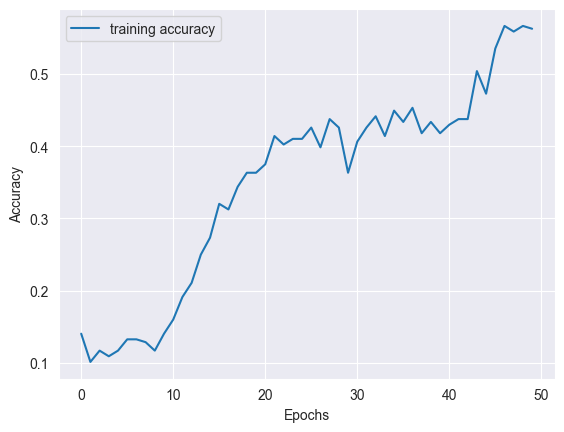

In [464]:
sns.lineplot(x=epochs,y=s1,label='training accuracy')
#sns.lineplot(x=epochs,y=s2,label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')